<a href="https://colab.research.google.com/github/Danie8904/prueba_NVIDIA_yahoo_Finance/blob/main/Nvidia_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proceso Modelamiento ML Ops - Yahoo Finance - Nvidia
## Realizado por Daniel Muñoz Palma

## Librerias

In [19]:
!pip install yfinance -q

In [20]:
import yfinance as yf

### 1. Punto: Extraer datos históricos de la compañía Nvidia y sus componentes desde Yahoo Finance utilizando Python

In [21]:
nvidia = yf.Ticker("NVDA")

# Se descargar datos históricos de NVDAD últimos 10 años
hist = nvidia.history(period="10y")

In [22]:
hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-06-18 00:00:00-04:00,0.526618,0.534363,0.525166,0.530974,299404000,0.0,0.0
2015-06-19 00:00:00-04:00,0.530974,0.535331,0.524440,0.529280,355656000,0.0,0.0
2015-06-22 00:00:00-04:00,0.530249,0.533153,0.519116,0.527102,514236000,0.0,0.0
2015-06-23 00:00:00-04:00,0.528070,0.532184,0.509435,0.513550,414064000,0.0,0.0
2015-06-24 00:00:00-04:00,0.512824,0.515486,0.506047,0.508467,253368000,0.0,0.0


In [23]:
# Exportación de datos a CSV
hist.to_csv("nvidia_10_anios.csv")

##  Gráfico Comportamiento histórico NVIDIA ("Precio de Cierre")

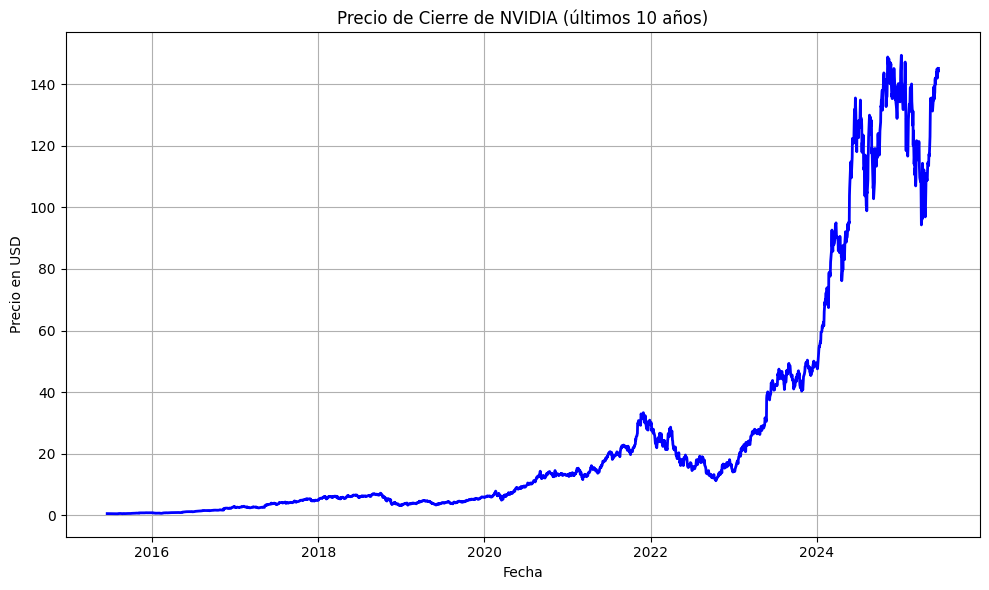

In [26]:
import matplotlib.pyplot as plt

hist = hist.reset_index()

plt.figure(figsize=(10, 6))
plt.plot(hist['Date'], hist['Close'], color='blue', linewidth=2)

plt.title("Precio de Cierre de NVIDIA (últimos 10 años)")
plt.xlabel("Fecha")
plt.ylabel("Precio en USD")
plt.grid(True)
plt.tight_layout()
plt.show()
